In [7]:
# Importing the needed libraries:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import math
import statistics
from scipy.stats import norm
# For debug purposes only. To be removed.
import time

In [8]:
# Meixner process parameters. No subordinator.
a = 0.1231
b = -0.5875
d = 3.3588

kappa = 0.5705
eta = 1.5863
lamb = 1.9592
y0 = 1

r = 1.9/100 
q = 1.2/100

S0 = 1124.47

In [9]:
def ch_price(t, K):  
    coth = lambda x : np.cosh(x)/np.sinh(x) 
    
    def phi_cir(u):
        gamma = np.sqrt(complex(kappa**2, -2*lamb**2*u))
        return np.exp(kappa**2*eta*t/(lamb**2))*np.exp(complex(0,2*y0*u)/(kappa + gamma*coth(gamma*t/2)))/((np.cosh(gamma*t/2) + kappa/gamma*np.sinh(gamma*t/2))**(2*kappa*eta/lamb**2))
    
    def psi_X(u):
        return np.log((np.cos(b/2)/np.cosh(complex(a*u,-b)/2))**(2*d))
    
    def phi(u):
        return np.exp(complex(0, u*((r-q)*t+np.log(S0))))*(phi_cir(complex(0,-psi_X(u))))/(phi_cir(complex(0,-psi_X(complex(0,-1)))))**complex(0,u)
    
    integrand1 = lambda u : np.real(np.exp(complex(0,-u)*np.log(K))*phi(complex(u,-1))/complex(0,u*phi(complex(0, -1))))
    integrand2 = lambda u : np.real(np.exp(complex(0,-u)*np.log(K))*phi(u)/complex(0,u))
    
    pi1 = 1/2 + 1/np.pi*(integrate.quad(integrand1, 0, 1000)[0])
    pi2 = 1/2 + 1/np.pi*(integrate.quad(integrand2, 0, 1000)[0])
    
    #return S0*pi1-K*np.exp(-r*t)*pi2
    return S0*np.exp(-q*t)*pi1-K*np.exp(-r*t)*pi2

In [10]:
ch_price(337/365, 1150)

68.20625728458583

In [11]:
K_list = [1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
prices_list = [146.50,96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8]
mc_predictions = []
for k in K_list:
    mc_predictions.append(ch_price(338/365,k))
closef_pricing = list(zip(prices_list, mc_predictions))
closef_pricing

[(146.5, 146.2682038274154),
 (96.2, 96.27854381660791),
 (81.7, 81.71991732622723),
 (68.3, 68.37017845752177),
 (56.6, 56.32144583474735),
 (46.1, 45.65767220010889),
 (36.9, 36.445043138549465),
 (29.3, 28.714744413693666),
 (22.5, 22.431730479365115),
 (17.2, 17.459460290552528),
 (12.8, 13.583692922767995)]

In [12]:
arpe = 1/len(closef_pricing)*sum([abs(market - model)/market for market, model in closef_pricing])
arpe

0.01180323208549623

### Pricing with Black-Scholes Formula

In [13]:
def blacks_formula(S0, T, K, r, q, sig):
    d1 = (np.log(S0/K)+(r-q+(sig**2)/2)*T)/(sig*np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    return math.exp(-q*T)*S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

In [14]:
blacks_formula(1124.47,338/365,1150,r,q, 0.1479)

55.044924877164476

In [15]:
K_list = [1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
prices_list = [146.50,96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8]
bs_predictions = []
for k in K_list:
    bs_predictions.append(blacks_formula(1124.47,338/365,k,r,q, 0.1479))
bs_pricing = list(zip(prices_list, bs_predictions))
#list(bs_pricing.values())
bs_pricing

[(146.5, 126.54488928955664),
 (96.2, 79.0555629606738),
 (81.7, 66.28698763237117),
 (68.3, 55.044924877164476),
 (56.6, 45.27231353292541),
 (46.1, 36.88317132044091),
 (36.9, 29.769743081677916),
 (29.3, 23.809957392336457),
 (22.5, 18.874516807101827),
 (17.2, 14.833129707541787),
 (12.8, 11.559587345897597)]

In [16]:
arpe = 1/len(bs_pricing)*sum([abs(market - model)/market for market, model in bs_pricing])
arpe

0.17031591253662542

### Implied Volatilities

##### Black Scholes

In [75]:
def implied_vol(sigma0,T, prices_list):
    #prices_list = [96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8]
    #K_nlist = [1025,1050, 1075, 1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
    K_nlist = [1025, 1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
    #K_nlist= list(range(1100,00,25))
    #K_nlist = [1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
    
    
    #mc_predictions = []
    #for k in K_nlist:
    #    mc_predictions.append(ch_price(337/365,k))
    #closef_pricing = dict(zip(K_nlist, mc_predictions))
    #p_list = list(closef_pricing.values())
    
    #sigma = np.zeros(len(K_nlist))
    #sigma[0]= sigma0
    sigmas = []
    for K_i, prices_K in zip(K_nlist, prices_list):
        sigma = sigma0
        for i in range(1000):
            sigma = sigma-((blacks_formula(S0, T, K_i, r, q, sigma)-prices_K)/(S0*np.sqrt(T)*norm.cdf((np.log(S0/K_i)+(r-q+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))))
            #sigma[i+1]= sigma[i]-((blacks_formula(S0, T, K_nlist[i], r, q, sigma[i])-prices_list[i])/(S0*np.sqrt(T)*norm.cdf((np.log(S0/K_nlist[i])+(r-q+(sigma[i]**2)/2)*T)/(sigma[i]*np.sqrt(T)))))
        sigmas.append(sigma)
    return dict(zip(K_nlist,sigmas))

In [51]:
imp = implied_vol(0.2,338/365)
#imp1 = implied_vol(0.2,S0,338/365,r,q)
#imp2 = implied_vol(0.2,S0,0.5,r,q)
#imp3 = implied_vol(0.2,S0,1.7,r,q)

In [52]:
imp

{1025: 0.20651234738352672,
 1100: 0.18941378153394042,
 1125: 0.18425397786771344,
 1150: 0.17895822609406267,
 1175: 0.17479725952095077,
 1200: 0.17052799898068,
 1225: 0.1663712450396331,
 1250: 0.16320141840295854,
 1275: 0.159013489602304,
 1300: 0.15602792259359044,
 1325: 0.1527745097934734}

Text(0, 0.5, 'Implied Volatility')

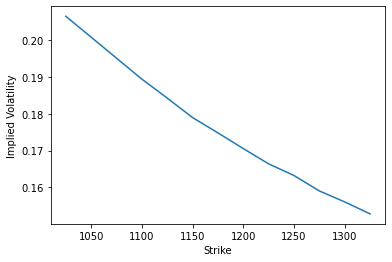

In [53]:
plt.plot(list(imp.keys()), list(imp.values()))
#plt.plot(list(imp1.keys()), list(imp1.values()))
#plt.plot(list(imp2.keys()), list(imp2.values()))
#plt.plot(list(imp3.keys()), list(imp3.values()))
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')


##### Closed form formula

In [68]:
imp_ch = implied_vol(0.2,1)

In [65]:
imp

{1025: 0.1971238329456603,
 1100: 0.1815858541705872,
 1125: 0.17651885757665434,
 1150: 0.17157082983475108,
 1175: 0.16680943725081476,
 1200: 0.16233463082415048,
 1225: 0.15828853366561532,
 1250: 0.1548543142232591,
 1275: 0.152209154739902,
 1300: 0.15040867179655992,
 1325: 0.1493547363151245}

Text(0.5, 1.0, 'IV for closed formula prices')

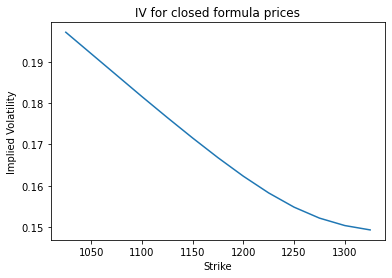

In [67]:
plt.plot(list(imp.keys()), list(imp.values()))
#plt.plot(list(imp1.keys()), list(imp1.values()))
#plt.plot(list(imp2.keys()), list(imp2.values()))
#plt.plot(list(imp3.keys()), list(imp3.values()))
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title("IV for closed formula prices")
#plt.ylim(0.18,0.22)

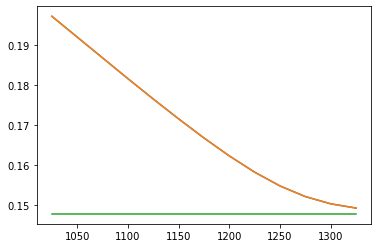

In [71]:
plt.plot(list(imp.keys()), list(imp.values()))
plt.plot(list(imp_ch.keys()), list(imp_ch.values()))
plt.plot(list(imp_ch.keys()), )
plt.plot(list(imp_ch.keys()), [0.1479 for i in imp.values()])


In [95]:
# predictions by closed formula
K_nlist = [1025, 1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
mc_predictions = []
for k in K_nlist:
    mc_predictions.append(ch_price(337/365,k))
    
imp_ch = implied_vol(0.2,1, mc_predictions)
imp_market = implied_vol(0.2,1, [146.50, 96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8])
imp_sub = implied_vol(0.2, 1, [142.51, 94.41, 81.49, 66.09, 54.72, 47.26, 36.25, 29.77, 24.12, 18.31, 15.99])

In [94]:
imp_market

{1025: 0.19815568997847846,
 1100: 0.18178699600632175,
 1125: 0.17685063770248957,
 1150: 0.17178232228945442,
 1175: 0.16780556440477035,
 1200: 0.16372282516810904,
 1225: 0.15974674891350368,
 1250: 0.15671871618403782,
 1275: 0.152709452089,
 1300: 0.14985541487471826,
 1325: 0.14674225552431516}

In [78]:
imp_market

{1025: nan,
 1100: 0.14795792641881347,
 1125: 0.14639582947892618,
 1150: 0.14538083391008294,
 1175: 0.14381022760731005,
 1200: 0.14198366238792887,
 1225: 0.14077987218818333,
 1250: 0.13838158377393533,
 1275: 0.13689316501500726,
 1300: 0.1349841279882195}

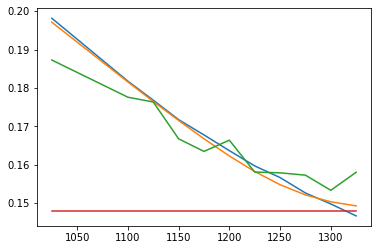

In [96]:
plt.plot(K_nlist, list(imp_market.values()))
plt.plot(K_nlist, list(imp_ch.values()))
plt.plot(K_nlist, list(imp_sub.values()))
plt.plot(K_nlist, [0.179 for i in K_nlist])